In [ ]:


#i20650 Saad Amir

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# to convert DataFrame to TensorDataset
def df_to_tensor(df):
    # Extract sketches and real images as numpy arrays and normalize
    sketches = np.stack(df['X (Sketch)'].values) / 255.0
    real_images = np.stack(df['Y (Real Image)'].values) / 255.0

    # Convert to PyTorch tensors
    sketches_tensor = torch.tensor(sketches, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    real_images_tensor = torch.tensor(real_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

    # Return as a TensorDataset
    return TensorDataset(sketches_tensor, real_images_tensor)

# Creating datasets and dataloaders
train_dataset = df_to_tensor(train_df)
test_dataset = df_to_tensor(test_df)
val_dataset = df_to_tensor(val_df)

# Define DataLoader for batching
batch_size = 40  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch
import torch.nn as nn

# Define Generator model i.e G: Sketch to Real nd  F: Real to Sketch
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Encoder
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # Bottleneck
            nn.Conv2d(256, 256, 4, 2, 1),
            nn.ReLU(),
            
            # Decoder
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:

# Setup models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models
G = Generator().to(device)  # Sketch to Real
F = Generator().to(device)  # Real to Sketch
D_X = Discriminator().to(device)  # Discriminator for Real Faces
D_Y = Discriminator().to(device)  # Discriminator for Sketches

# Define loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Define optimizers
lr = 0.0002
optimizer_G = torch.optim.Adam(list(G.parameters()) + list(F.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=(0.5, 0.999))



epochs=10

# Function to save model weights
def save_models(epoch):
    torch.save(G.state_dict(), f'generator_G_epoch_{epoch}.pth')
    torch.save(F.state_dict(), f'generator_F_epoch_{epoch}.pth')
    torch.save(D_X.state_dict(), f'discriminator_DX_epoch_{epoch}.pth')
    torch.save(D_Y.state_dict(), f'discriminator_DY_epoch_{epoch}.pth')
    print(f"Models saved at epoch {epoch}")

# Initialize lists to store loss values separately for G and F generators
G_losses, F_losses = [], []
D_X_losses, D_Y_losses = [], []

for epoch in range(epochs):
    for i, (sketches, real_images) in enumerate(train_loader):
        sketches, real_images = sketches.to(device), real_images.to(device)

        # Train Generators G and F
        optimizer_G.zero_grad()

        # Identity loss
        loss_identity_X = criterion_identity(G(real_images), real_images) * 5.0
        loss_identity_Y = criterion_identity(F(sketches), sketches) * 5.0

        # GAN loss for G and F
        fake_real = G(sketches)
        pred_fake = D_X(fake_real)
        loss_G_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_sketch = F(real_images)
        pred_fake = D_Y(fake_sketch)
        loss_F_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        # Cycle consistency loss for G and F
        recov_sketch = F(fake_real)
        loss_G_cycle = criterion_cycle(recov_sketch, sketches) * 10.0

        recov_real = G(fake_sketch)
        loss_F_cycle = criterion_cycle(recov_real, real_images) * 10.0

        # Total generator losses
        loss_G_total = loss_identity_X + loss_G_GAN + loss_G_cycle
        loss_F_total = loss_identity_Y + loss_F_GAN + loss_F_cycle

        # Combined generator loss (same as before)
        total_generator_loss = loss_G_total + loss_F_total
        total_generator_loss.backward()
        optimizer_G.step()

        # Train Discriminator D_X
        optimizer_D_X.zero_grad()
        pred_real = D_X(real_images)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        pred_fake = D_X(fake_real.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D_X = (loss_D_real + loss_D_fake) * 0.5
        loss_D_X.backward()
        optimizer_D_X.step()

        # Train Discriminator D_Y
        optimizer_D_Y.zero_grad()
        pred_real = D_Y(sketches)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        pred_fake = D_Y(fake_sketch.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D_Y = (loss_D_real + loss_D_fake) * 0.5
        loss_D_Y.backward()
        optimizer_D_Y.step()

        # Store individual losses
        G_losses.append(loss_G_total.item())
        F_losses.append(loss_F_total.item())
        D_X_losses.append(loss_D_X.item())
        D_Y_losses.append(loss_D_Y.item())

        # Display progress every 50 steps
        if (i+1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"D_X Loss: {loss_D_X.item():.4f}, D_Y Loss: {loss_D_Y.item():.4f}, "
                  f"G Loss: {loss_G_total.item():.4f}, F Loss: {loss_F_total.item():.4f}")

    # Print losses at the end of each epoch
    print(f"Epoch [{epoch+1}/{epochs}], G Loss: {loss_G_total.item()}, F Loss: {loss_F_total.item()}, "
          f"D_X Loss: {loss_D_X.item()}, D_Y Loss: {loss_D_Y.item()}")



Epoch [1/10], Step [50/517], D_X Loss: 0.0138, D_Y Loss: 0.0039, G Loss: 5.7706, F Loss: 4.4576
Epoch [1/10], Step [100/517], D_X Loss: 0.0039, D_Y Loss: 0.0018, G Loss: 4.7215, F Loss: 3.6120
Epoch [1/10], Step [150/517], D_X Loss: 0.0018, D_Y Loss: 0.0030, G Loss: 3.7122, F Loss: 3.1977
Epoch [1/10], Step [200/517], D_X Loss: 0.0023, D_Y Loss: 0.1668, G Loss: 2.4467, F Loss: 2.1234
Epoch [1/10], Step [250/517], D_X Loss: 0.0013, D_Y Loss: 0.1074, G Loss: 2.1945, F Loss: 2.0838
Epoch [1/10], Step [300/517], D_X Loss: 0.1229, D_Y Loss: 0.1728, G Loss: 1.7315, F Loss: 1.7460
Epoch [1/10], Step [350/517], D_X Loss: 0.1999, D_Y Loss: 0.1387, G Loss: 1.3901, F Loss: 1.7872
Epoch [1/10], Step [400/517], D_X Loss: 0.2485, D_Y Loss: 0.0845, G Loss: 1.4122, F Loss: 1.6372
Epoch [1/10], Step [450/517], D_X Loss: 0.1733, D_Y Loss: 0.0803, G Loss: 1.5419, F Loss: 1.5618
Epoch [1/10], Step [500/517], D_X Loss: 0.1783, D_Y Loss: 0.0980, G Loss: 1.4351, F Loss: 1.5573
Epoch [1/10], G Loss: 1.3558884

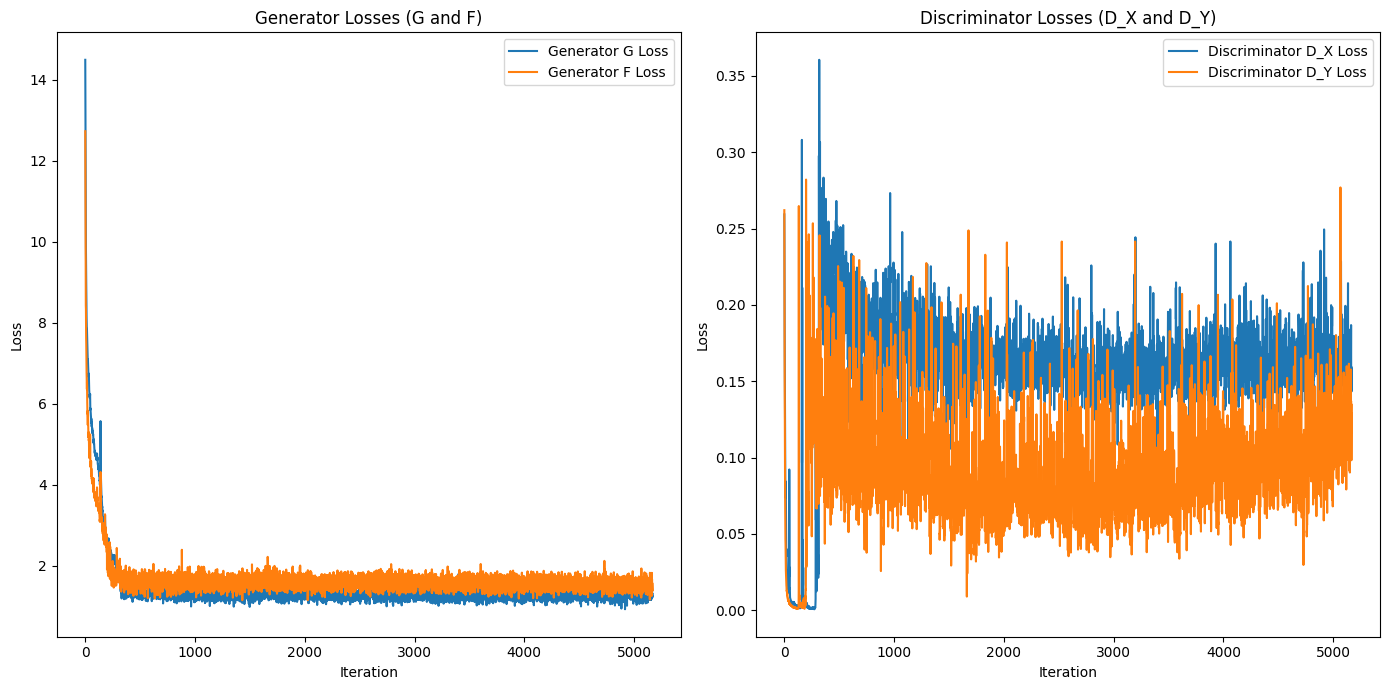

In [9]:
# Plot the generator and discriminator losses
plt.figure(figsize=(14, 7))

# Plot G and F generator losses
plt.subplot(1, 2, 1)
plt.plot(G_losses, label='Generator G Loss')
plt.plot(F_losses, label='Generator F Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator Losses (G and F)')
plt.legend()

# Plot discriminator losses
plt.subplot(1, 2, 2)
plt.plot(D_X_losses, label='Discriminator D_X Loss')
plt.plot(D_Y_losses, label='Discriminator D_Y Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Discriminator Losses (D_X and D_Y)')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# End of training loop
print("Training complete. Saving models...")

# Save all four models
torch.save(G.state_dict(), 'generator_G.pth')
torch.save(F.state_dict(), 'generator_F.pth')
torch.save(D_X.state_dict(), 'discriminator_D_X.pth')
torch.save(D_Y.state_dict(), 'discriminator_D_Y.pth')

print("Models saved successfully.")


Training complete. Saving models...
Models saved successfully.


In [29]:
# Initialize the models
G = Generator()
F = Generator()
D_X = Discriminator()
D_Y = Discriminator()

# Set the models to use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G, F, D_X, D_Y = G.to(device), F.to(device), D_X.to(device), D_Y.to(device)

# Load the model weights
G.load_state_dict(torch.load('generator_G.pth', map_location=device))
F.load_state_dict(torch.load('generator_F.pth', map_location=device))
D_X.load_state_dict(torch.load('discriminator_D_X.pth', map_location=device))
D_Y.load_state_dict(torch.load('discriminator_D_Y.pth', map_location=device))

print("Models loaded successfully.")


Models loaded successfully.


C:\Users\samee\AppData\Local\Temp\ipykernel_28652\4067333961.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('generator_G.pth', map_locatio

In [36]:
def display_results(input_img, gen_output, title1, title2):
    # Ensure the tensors are squeezed to remove any extra batch or channel dimensions
    input_img = input_img.squeeze().cpu().numpy()
    gen_output = gen_output.squeeze().cpu().numpy()

    # Handle additional dimensions for grayscale images (in case of (40, 128, 128) shape)
    if input_img.ndim == 3:
        input_img = input_img[0]  # Take the first channel for grayscale
    if gen_output.ndim == 3:
        gen_output = gen_output[0]  # Take the first channel for grayscale

    # Ensure the data is in a 2D shape for grayscale
    assert input_img.ndim == 2, f"Expected 2D image data for input_img, but got {input_img.shape}"
    assert gen_output.ndim == 2, f"Expected 2D image data for gen_output, but got {gen_output.shape}"

    # Plot the images
    plt.figure(figsize=(8, 4))
    
    # Display input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_img, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    
    # Display generated output
    plt.subplot(1, 2, 2)
    plt.imshow(gen_output, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    
    plt.show()


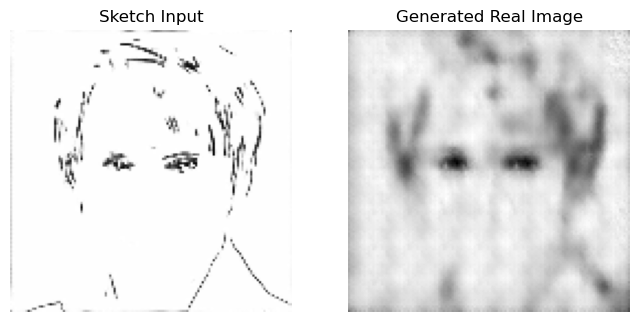

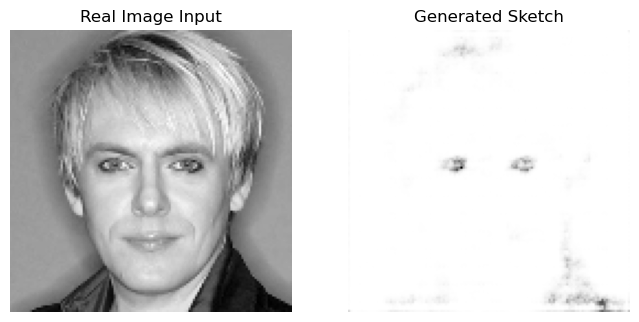

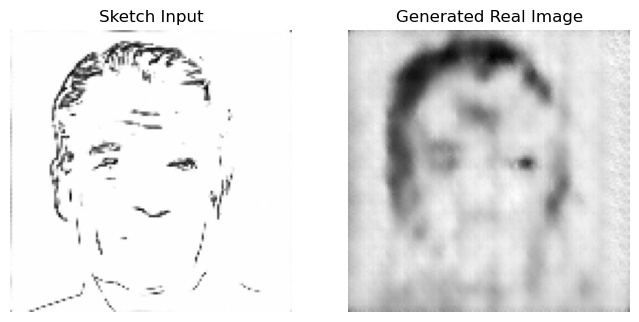

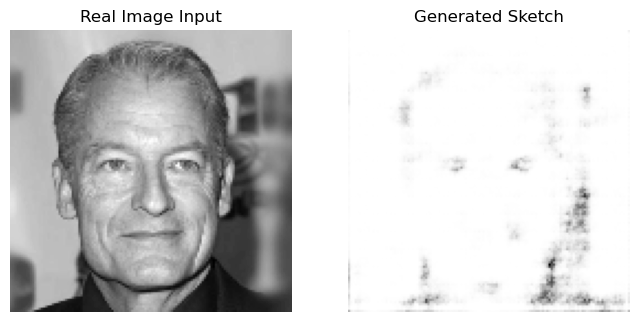

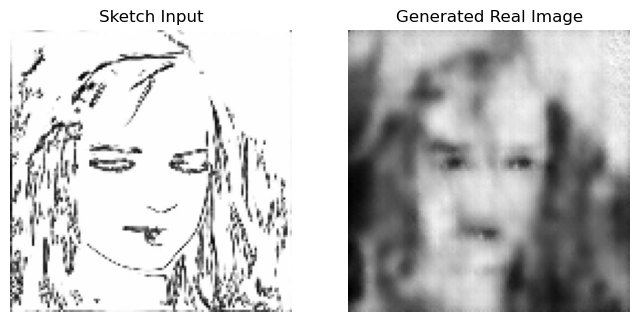

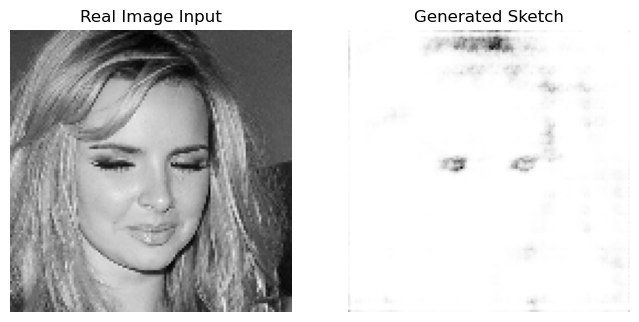

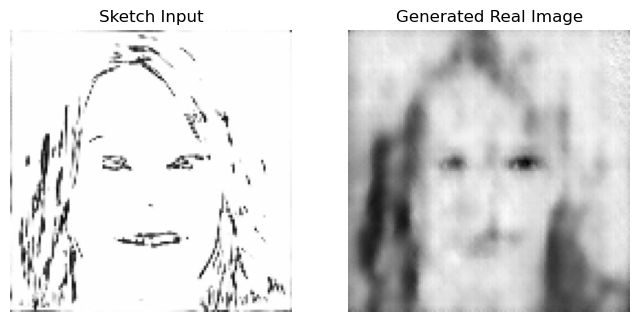

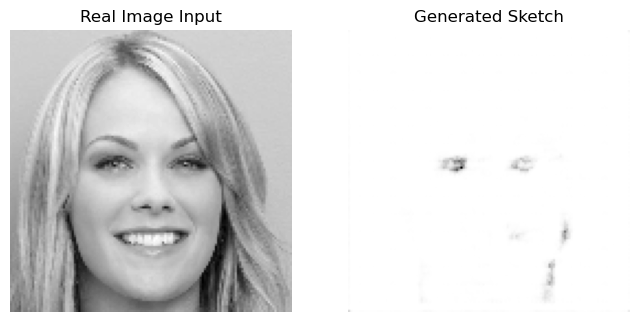

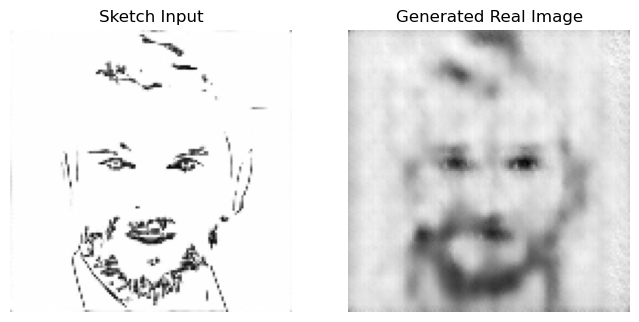

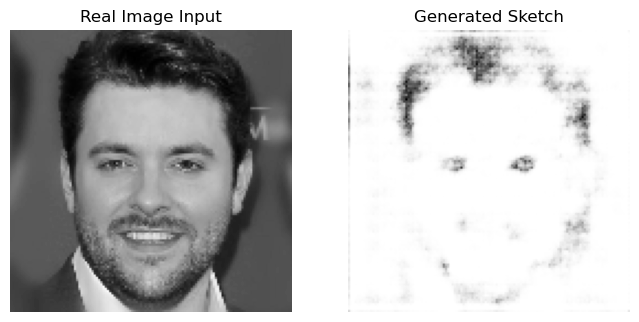

In [37]:
# Set models to evaluation mode
G.eval()
F.eval()

# Run inference on the test dataset
with torch.no_grad():  # Disable gradient computation for testing
    for i, (sketch, real_img) in enumerate(test_loader):
        sketch, real_img = sketch.to(device), real_img.to(device)
        
        # Use generator G: Sketch -> Real Image
        generated_real = G(sketch)
        display_results(sketch, generated_real, 'Sketch Input', 'Generated Real Image')
        
        # Use generator F: Real Image -> Sketch
        generated_sketch = F(real_img)
        display_results(real_img, generated_sketch, 'Real Image Input', 'Generated Sketch')
        
        # Display results for the first few samples only
        if i >= 4:
            break
